In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf
from scipy.signal import lfilter

OLSBLMS Adaptation completed in 23.072 ms


C:\Users\bruno\AppData\Local\Temp\ipykernel_14236\481443567.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M = int(data['M']) # Número de sub-bandas (4)


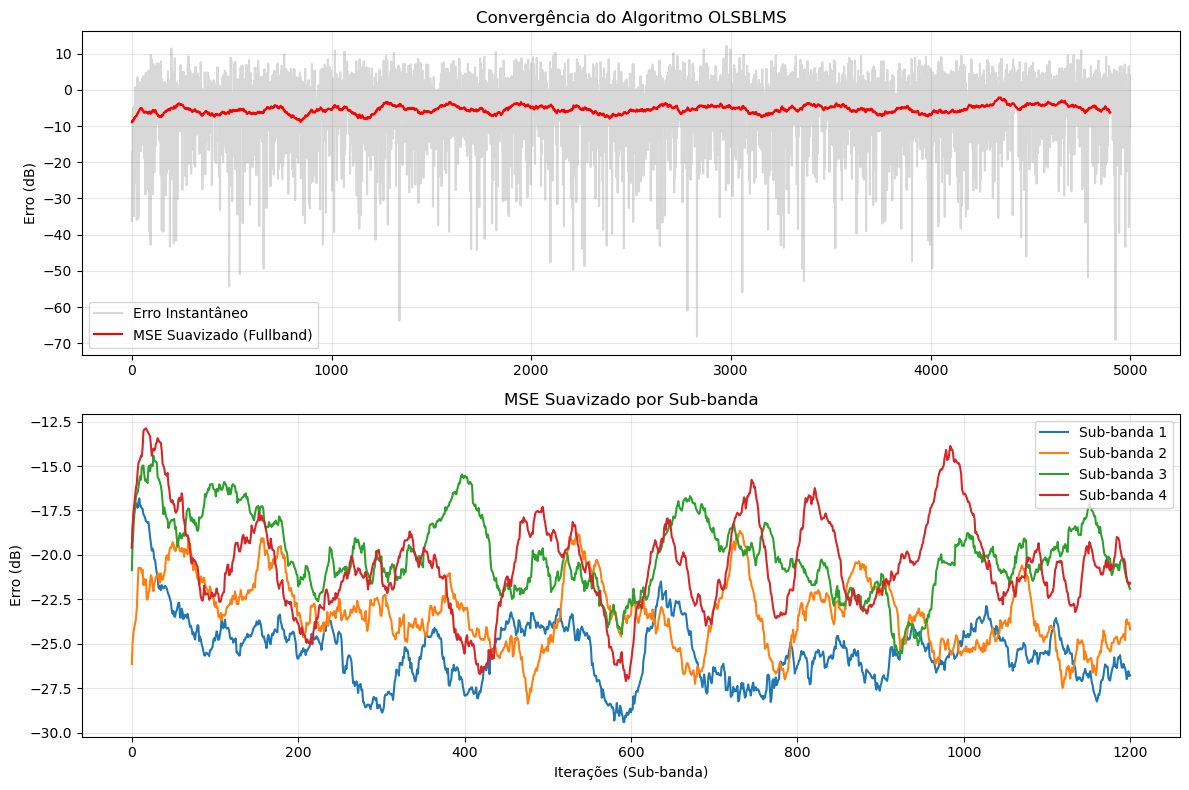

MSE Final (Overall): -20.65 dB


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1. Carregar os filtros do arquivo enviado (cosmod_4_64.mat)
# Este arquivo contém as matrizes 'hk' (análise) e 'fk' (síntese)
data = loadmat('cosmod_4_64.mat')
hk = data['hk']
fk = data['fk']
M = int(data['M']) # Número de sub-bandas (4)

# 2. Parâmetros da Simulação
n_samples = 5000
Nw = 15          # Ordem do filtro em cada sub-banda
step = 0.05      # Passo de convergência (u)

# Criar um sistema desconhecido (Planta FIR)
w_unknown = np.random.randn(64) 
w_unknown /= np.linalg.norm(w_unknown)

# Gerar sinais
x = np.random.randn(n_samples) # Entrada: Ruído Branco
d_clean = np.convolve(x, w_unknown, mode='full')[:n_samples]
noise = 0.01 * np.random.randn(n_samples)
d = d_clean + noise # Sinal desejado com ruído

# 3. Instanciar e Rodar o OLSBLMS
# (Certifique-se de que a classe OLSBLMS definida por você esteja na célula acima)
flt = pdf.OLSBLMS(
    n_subbands=M,
    analysis_filters=hk,
    synthesis_filters=fk,
    filter_order=Nw,
    step=step,
    gamma=1e-2,
    a=0.01
)

results = flt.optimize(x, d, verbose=True)

# 4. Visualização dos Resultados
plt.figure(figsize=(12, 8))

# Subplot 1: Erro Fullband (Reconstruído)
plt.subplot(2, 1, 1)
mse_db = 10 * np.log10(results["errors"]**2 + 1e-10)
plt.plot(mse_db, color='gray', alpha=0.3, label='Erro Instantâneo')
plt.plot(np.convolve(mse_db, np.ones(100)/100, mode='valid'), color='red', label='MSE Suavizado (Fullband)')
plt.title("Convergência do Algoritmo OLSBLMS")
plt.ylabel("Erro (dB)")
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Erros Individuais por Sub-banda
plt.subplot(2, 1, 2)
for m in range(M):
    mse_sb = 10 * np.log10(results["mse_subbands"][m] + 1e-10)
    plt.plot(np.convolve(mse_sb, np.ones(50)/50, mode='valid'), label=f'Sub-banda {m+1}')

plt.title("MSE Suavizado por Sub-banda")
plt.xlabel("Iterações (Sub-banda)")
plt.ylabel("Erro (dB)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final (Overall): {10*np.log10(results['mse_overall'][-1]):.2f} dB")